In [1]:
import pandas as pd  
import glob
import os

tasks = ['Natural', 'Dog', 'Adversarial_Nat', 'Adversarial_Dog']
dataset_path = '/home/dexter/Downloads/Human_experiments/Dataset'
ground_truth = dict()

# Build the ground truth dictionary 

CORRECT_BIN1_IMAGES = 'correct_bin1_images/'
CORRECT_BIN2_IMAGES = 'correct_bin2_images/'
CORRECT_BIN3_IMAGES = 'correct_bin3_images/'
WRONG_BIN1_IMAGES = 'wrong_bin1_images/'
WRONG_BIN2_IMAGES = 'wrong_bin2_images/'
WRONG_BIN3_IMAGES = 'wrong_bin3_images/'
bin_images = [CORRECT_BIN1_IMAGES, CORRECT_BIN2_IMAGES, CORRECT_BIN3_IMAGES, WRONG_BIN1_IMAGES, WRONG_BIN2_IMAGES, WRONG_BIN3_IMAGES]
easy_bins = [WRONG_BIN1_IMAGES, CORRECT_BIN3_IMAGES]
hard_bins = [CORRECT_BIN1_IMAGES, WRONG_BIN3_IMAGES]
norm_bins = [CORRECT_BIN2_IMAGES, WRONG_BIN2_IMAGES]


for task in tasks:
    ground_truth[task] = dict()
    task_dataset_path = os.path.join(dataset_path,task)
    for CORRECT_BIN_IMAGES in [CORRECT_BIN1_IMAGES, CORRECT_BIN2_IMAGES, CORRECT_BIN3_IMAGES]:
        bin_gt_dict = dict()
        correct_bin_images_path = os.path.join(task_dataset_path, CORRECT_BIN_IMAGES)
        correct_bin_images = [path.split(CORRECT_BIN_IMAGES)[1] for path in glob.glob(correct_bin_images_path + '/*.*')]
        for correct_bin_image in correct_bin_images:
            bin_gt_dict[correct_bin_image] = 'Yes'
        
        ground_truth[task][CORRECT_BIN_IMAGES] = bin_gt_dict
        
    for WRONG_BIN_IMAGES in [WRONG_BIN1_IMAGES, WRONG_BIN2_IMAGES, WRONG_BIN3_IMAGES]:
        bin_gt_dict = dict()
        wrong_bin_images_path = os.path.join(task_dataset_path, WRONG_BIN_IMAGES)
        wrong_bin_images = [path.split(WRONG_BIN_IMAGES)[1] for path in glob.glob(wrong_bin_images_path + '/*.*')]
        for wrong_bin_image in wrong_bin_images:
            bin_gt_dict[wrong_bin_image] = 'No'
        
        ground_truth[task][WRONG_BIN_IMAGES] = bin_gt_dict

In [2]:
import pandas as pd  
import operator
import os
import math
import statistics
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Check if a number is float?
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Task aliases assigned by Gorilla
exp_hierarchy = ['randomiser-tjl7', {'Conf':'counterbalance-lxdj', 'GradCAM': 'counterbalance-yqqs', 'EP': 'counterbalance-jiws', 'SOD': 'counterbalance-eqty', 'NNs': 'counterbalance-xsf1'}]

methods = ['Conf', 'GradCAM', 'EP', 'SOD', 'NNs']
dataset_path = '/home/dexter/Downloads/Human_experiments/Dataset'

# Loop all csv file, each csv file is an explanation method
files = []

exp = 'Dog'
for file in glob.glob('Data/{}/*.*'.format(exp)):
    if '.csv' in file:
        files.append(file)

if exp == 'Natural':
    tasks = ['Natural', 'Adversarial_Nat']
    threshold = 10
else:
    tasks = ['Dog', 'Adversarial_Dog']
    threshold = 8
    
csv_file = open('tmp/{}_bad_users.csv'.format(tasks[0]), 'w')
final_result = dict()
trial_cnt = dict()

# Initialize the dictionary for users' responses (answer)
for task in tasks:
    final_result[task] = dict()
    trial_cnt[task] = dict()
    for method in methods:
        final_result[task][method] = dict()
        trial_cnt[task][method] = dict()
        for bin_image in bin_images:
            final_result[task][method][bin_image] = 0
            trial_cnt[task][method][bin_image] = 0

# Correct answer dictionary in validation 
val_correct_dict = dict()
# Incorrect answer dictionary in validation 
val_incorrect_trials_dict = dict()

test_correct_trials_dict = dict()
test_incorrect_trials_dict = dict()

# Numbers of users for methods
user_cnt_dict = dict()

# Reaction time dictionary 
users_avg_reaction_time_dict = dict()
users_stdev_reaction_time_dict = dict()
below_stdev_reaction_time_dict = dict()

# Counter-balances for methods
counter_balances_dict = dict()

# Numbers of good users for methods
good_user_cnt_dict = dict()
good_user_cnt = 0
bad_user_cnt = 0
users_reaction_times = []
user_dict = dict()

for file in files:
    reaction_time_correct_cnt_dict = dict()
    users_reaction_time = []
    users_val_incorrect_trials = []
    counter_balances = []
    user_cnt = 0
    df = pd.read_csv(file)
#     reaction_time = (df['Reaction Time'].sum()/1000)/60 # in minutes
    for index, row in df.iterrows():
        
        # Start the spreadsheet for a user
        if row['Event Index'] != 'END OF FILE' and int(row['Event Index']) == 1:
            user_cnt += 1
#             print('-------- STATISTICS FOR USER NUMBER {} --------'.format(user_cnt))
            reaction_time = 0
            reaction_times = []

            val_correct = 0
            val_incorrect = 0
            val_incorrect_trials = []
            val_trial_cnt = 0
            
            test_reaction_time = 0
            val_reaction_time = 0

            test_trial_answers = {}

            task_name = row['Task Name']
#             print(task_name)
            method = task_name.split('_')[1]
            if method == 'Confidence':
                method = 'Conf'

            task = task_name.split('_')[0]
            counter_balance = int(row[exp_hierarchy[1][method]])
# #             print(task_name, method, counter_balance)
#             counter_balances.append(counter_balance)

            public_id = row['Participant Public ID']
    
            if task not in user_dict:
                user_dict[task] = dict()
                    
            if method not in user_dict[task]:
                user_dict[task][method] = dict()
            if public_id not in user_dict[task][method]:
                user_dict[task][method][public_id] = dict()
                user_dict[task][method][public_id]['Trials'] = dict()
                user_dict[task][method][public_id]['Prior Knowledge'] = dict()
                user_dict[task][method][public_id]['Counter balance'] = counter_balance
                user_dict[task][method][public_id]['Known'] = 0
                user_dict[task][method][public_id]['Unknown'] = 0
        
        trial_time = row['Reaction Time']
        
#         # Get the reaction time for each screen
#         if (isinstance(trial_time, str) and is_float(trial_time)) or (isinstance(trial_time, float) and not math.isnan(trial_time)):
#             reaction_time += float(trial_time)
#             reaction_times.append(float(trial_time))
            
        # Check users' responses in validation
        if row['display'] == 'Validation' and row['Screen Name'] == 'Screen 3':
            val_trial_cnt += 1
            if row['Correct'] == 1:
                val_correct += 1
            elif row['Incorrect'] == 1:
                val_incorrect += 1
                val_incorrect_trials.append(val_trial_cnt)
            else:
                raise ValueError("Wrong value!")
                
            user_dict[task][method][public_id]['Validation Correct'] = val_correct
            user_dict[task][method][public_id]['Validation Incorrect'] = val_incorrect
            user_dict[task][method][public_id]['Incorrect Validation Trials'] = val_incorrect_trials
            
        elif row['display'] == 'Trial' and row['Screen Name'] == 'Screen 1':
            prior_knowledge = row['Response']
                
        # Check users' responses in test
        elif row['display'] == 'Trial' and row['Screen Name'] == 'Screen 3':
            file_name = row['file_name' + str(counter_balance)]
            file_name = (file_name.split('.jpeg')[0]).split('_')[:-1]
            file_name = '_'.join(file_name) + '.jpeg'
            test_trial_answers[file_name] = row['Response']
            
            user_dict[task][method][public_id]['Trials'][file_name] = row['Response']
            user_dict[task][method][public_id]['Prior Knowledge'][file_name] = prior_knowledge
        
        # Time from instructions -> the end of Validation
        if row['display'] != 'Trial':
            if (isinstance(row['Reaction Time'], str) and is_float(row['Reaction Time'])) or (isinstance(row['Reaction Time'], float) and not math.isnan(row['Reaction Time'])):
                val_reaction_time += float(row['Reaction Time'])
        
        # End the spreadsheet for a user
        if row['Trial Number'] == 'END TASK':
            reaction_time = float(row['Reaction Time'])
            
            # Validation and Test are combined
            user_dict[task][method][public_id]['Validation Reaction Time'] = val_reaction_time
            user_dict[task][method][public_id]['Test Reaction Time'] = reaction_time - test_reaction_time
            
            
import pandas as pd  
import operator
import os
import math
import statistics
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Check if a number is float?
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Task aliases assigned by Gorilla
exp_hierarchy = ['randomiser-tjl7', {'Conf':'counterbalance-lxdj', 'GradCAM': 'counterbalance-yqqs', 'EP': 'counterbalance-jiws', 'SOD': 'counterbalance-eqty', 'NNs': 'counterbalance-xsf1'}]

if exp == 'Natural':
    validation_task_names = ['task-34jo', 'task-hd4d']
    test_task_names = ['task-ad35', 'task-v2vz']
else:
    validation_task_names = ['task-phxr', 'task-w7x5']
    test_task_names = ['task-qa38', 'task-wpt2']

methods = ['Conf', 'GradCAM', 'EP', 'SOD', 'NNs']
dataset_path = '/home/dexter/Downloads/Human_experiments/Dataset'

# Loop all csv file, each csv file is an explanation method
files = []
for file in glob.glob('Data-v2/{}/*.*'.format(exp)):
    if '.csv' in file:
        files.append(file)
        
csv_file = open('tmp/{}_bad_users.csv'.format(tasks[0]), 'w')
final_result = dict()

# Correct answer dictionary in validation 
val_correct_dict = dict()
# Incorrect answer dictionary in validation 
val_incorrect_trials_dict = dict()

test_correct_trials_dict = dict()
test_incorrect_trials_dict = dict()

# Numbers of users for methods
user_cnt_dict = dict()

# Reaction time dictionary 
users_avg_reaction_time_dict = dict()
users_stdev_reaction_time_dict = dict()
below_stdev_reaction_time_dict = dict()

# Counter-balances for methods
counter_balances_dict = dict()

# Numbers of good users for methods
good_user_cnt_dict = dict()
good_user_cnt = 0
bad_user_cnt = 0
users_reaction_times = []
# user_dict = dict()

for file in files:
    reaction_time_correct_cnt_dict = dict()
    users_reaction_time = []
    users_val_incorrect_trials = []
    counter_balances = []
    user_cnt = 0
    df = pd.read_csv(file)
#     reaction_time = (df['Reaction Time'].sum()/1000)/60 # in minutes
    for index, row in df.iterrows():
        
        # Start the spreadsheet for a user
        if row['Event Index'] != 'END OF FILE' and int(row['Event Index']) == 1:
#             print('-------- STATISTICS FOR USER NUMBER {} --------'.format(user_cnt))
            reaction_time = 0
            reaction_times = []

            val_correct = 0
            val_incorrect = 0
            val_incorrect_trials = []
            val_trial_cnt = 0
            
            prior_knowledge_dict = dict() # To process mismatched answers in prior knowledge test

            test_trial_answers = {}

            task_name = row['Task Name']
#             print(task_name)
            method = task_name.split('_')[1]
            if method == 'Confidence':
                method = 'Conf'

            task = task_name.split('_')[0]
            counter_balance = int(row[exp_hierarchy[1][method]])
# #             print(task_name, method, counter_balance)
#             counter_balances.append(counter_balance)

            public_id = row['Participant Public ID']
    
            if task not in user_dict:
                user_dict[task] = dict()
                    
            if method not in user_dict[task]:
                user_dict[task][method] = dict()
            if public_id not in user_dict[task][method]:
                user_dict[task][method][public_id] = dict()
                user_dict[task][method][public_id]['Trials'] = dict()
                user_dict[task][method][public_id]['Counter balance'] = counter_balance
                user_dict[task][method][public_id]['Prior Knowledge'] = dict()
                user_dict[task][method][public_id]['Known'] = 0
                user_dict[task][method][public_id]['Unknown'] = 0
            
        # Check users' responses in validation
        if row['display'] == 'Validation' and row['Screen Name'] == 'Screen 3':
            val_trial_cnt += 1
            if row['Correct'] == 1:
                val_correct += 1
            elif row['Incorrect'] == 1:
                val_incorrect += 1
                val_incorrect_trials.append(val_trial_cnt)
            else:
                raise ValueError("Wrong value!")
                
            user_dict[task][method][public_id]['Validation Correct'] = val_correct
            user_dict[task][method][public_id]['Validation Incorrect'] = val_incorrect
            user_dict[task][method][public_id]['Incorrect Validation Trials'] = val_incorrect_trials
            
        elif row['display'] == 'Trial' and row['Screen Name'] == 'Screen 1':
            prior_knowledge = row['Response']
                
        # Check users' responses in test
        elif row['display'] == 'Trial' and row['Screen Name'] == 'Screen 3':
            file_name = row['file_name' + str(counter_balance)]
            file_name = (file_name.split('.jpeg')[0]).split('_')[:-1]
            file_name = '_'.join(file_name) + '.jpeg'
            test_trial_answers[file_name] = row['Response']
            
            user_dict[task][method][public_id]['Trials'][file_name] = row['Response']
            
            # file_name[:9] is the predicted ID
            # If someones said unknown to a class, the same classes in the test should be also unknown
            if file_name[:9] not in prior_knowledge_dict:
                prior_knowledge_dict[file_name[:9]] = prior_knowledge

            user_dict[task][method][public_id]['Prior Knowledge'][file_name] = prior_knowledge_dict[file_name[:9]]
                
                
        # End the spreadsheet for a user
        if row['Trial Number'] == 'END TASK':
            reaction_time = float(row['Reaction Time'])
            
            # Validation and Test are separated
            if row['Tree Node Key'] in validation_task_names:
                user_dict[task][method][public_id]['Validation Reaction Time'] = reaction_time
            else:
                user_dict[task][method][public_id]['Test Reaction Time'] = reaction_time


/home/dexter/miniconda3/envs/advanced_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/dexter/miniconda3/envs/advanced_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


User_dict
- Natural
    - Methods
        - User_IDs
            - ['Trials', '
            - Counter balance', 
            - 'Validation Correct', ' # The number of correct validation trials
            - Validation Incorrect', ' # The number of incorrect validation trials
            - Incorrect Validation Trials', ' # The IDs of incorrect validation trials
            - Validation Reaction Time', '#  # Time from instructions -> the end of Validation
            - Test Reaction Time', ' # Time taken for 30 test trials
            - Quality']) # This user qualified the validation or not.

In [3]:
test_correct_trials_dict = dict()

# Initialize the dictionary for users' responses (answer)
for task in tasks:
    final_result[task] = dict()
    trial_cnt[task] = dict()
    for method in methods:
        final_result[task][method] = dict()
        trial_cnt[task][method] = dict()
        for bin_image in bin_images:
            final_result[task][method][bin_image] = 0
            trial_cnt[task][method][bin_image] = 0

task = exp
for method in methods:
    good_user_cnt = 0
    hacking_user_cnt = 0
    correct_cnt_list = []
    
    if method not in test_correct_trials_dict:
        test_correct_trials_dict[method] = dict()
    
    for user_id in user_dict[task][method].keys():
        user_dict[task][method][user_id]['Known'] = 0
        user_dict[task][method][user_id]['Unknown'] = 0
    
        if user_dict[task][method][user_id]['Validation Correct'] >= threshold:
            good_user_cnt += 1
            user_dict[task][method][user_id]['Quality'] = 'Good'
        else:
            user_dict[task][method][user_id]['Quality'] = 'Bad'
#             if user_dict[task][method][user_id]['Test Reaction Time'] < 1*user_dict[task][method][user_id]['Validation Reaction Time']:
#                 hacking_user_cnt += 1
            continue
        
        trials = user_dict[task][method][user_id]['Trials']
        
        # Initialize: The correct times a trial gets {trial_name: times}
        for trial_key in trials.keys():
            if trial_key not in test_correct_trials_dict[method]:
                test_correct_trials_dict[method][trial_key] = dict()
                test_correct_trials_dict[method][trial_key]['Count'] = 0
                test_correct_trials_dict[method][trial_key]['Counter balance'] = list()
            test_correct_trials_dict[method][trial_key]['Counter balance'].append(user_dict[task][method][user_id]['Counter balance'])
                
        if task == 'Natural':
            task_list = ['Natural', 'Adversarial_Nat']
        elif task == 'Dog':
            task_list = ['Dog', 'Adversarial_Dog']
            
        # Record the number of correct answers of a user for every bin
        for sub_task in task_list: 
            user_dict[task][method][user_id][sub_task] = dict()
            exp_gt = ground_truth[sub_task]

            for CORRECT_BIN_IMAGES in [CORRECT_BIN1_IMAGES, CORRECT_BIN2_IMAGES, CORRECT_BIN3_IMAGES]:
                shared_items = {k: exp_gt[CORRECT_BIN_IMAGES][k] for k in exp_gt[CORRECT_BIN_IMAGES] if k in trials and exp_gt[CORRECT_BIN_IMAGES][k] == trials[k]}
                user_dict[task][method][user_id][sub_task][CORRECT_BIN_IMAGES] = len(shared_items)
                
                # Get: The correct times a trial gets {trial_name: times}
                for key in shared_items.keys():
                    test_correct_trials_dict[method][key]['Count'] += 1
                    test_correct_trials_dict[method][key]['Task'] = sub_task
                    if user_dict[task][method][user_id]['Prior Knowledge'][key] == 'Yes':
                        user_dict[task][method][user_id]['Known'] += 1
                    else:
                        user_dict[task][method][user_id]['Unknown'] += 1
                
                # Get: The prediction of AI on this image
                for key in exp_gt[CORRECT_BIN_IMAGES].keys():
                    if key in test_correct_trials_dict[method]:
                        test_correct_trials_dict[method][key]['Prediction'] = 'Correct'
                
                trial_cnt[sub_task][method][CORRECT_BIN_IMAGES] += len(set.intersection(set(ground_truth[sub_task][CORRECT_BIN_IMAGES].keys()), set(trials.keys())))
                
            for WRONG_BIN_IMAGES in [WRONG_BIN1_IMAGES, WRONG_BIN2_IMAGES, WRONG_BIN3_IMAGES]:
                shared_items = {k: exp_gt[WRONG_BIN_IMAGES][k] for k in exp_gt[WRONG_BIN_IMAGES] if k in trials and exp_gt[WRONG_BIN_IMAGES][k] == trials[k]}
                user_dict[task][method][user_id][sub_task][WRONG_BIN_IMAGES] = len(shared_items)
                
                # Get: The correct times a trial gets {trial_name: times}                    
                for key in shared_items.keys():
                    test_correct_trials_dict[method][key]['Count'] += 1
                    test_correct_trials_dict[method][key]['Task'] = sub_task
                    if user_dict[task][method][user_id]['Prior Knowledge'][key] == 'Yes':
                        user_dict[task][method][user_id]['Known'] += 1
                    else:
                        user_dict[task][method][user_id]['Unknown'] += 1
                    
                # Get: The prediction of AI on this image
                for key in exp_gt[WRONG_BIN_IMAGES].keys():
                    if key in test_correct_trials_dict[method]:
                        test_correct_trials_dict[method][key]['Prediction'] = 'Wrong'

                trial_cnt[sub_task][method][WRONG_BIN_IMAGES] += len(set.intersection(set(ground_truth[sub_task][WRONG_BIN_IMAGES].keys()), set(trials.keys())))
        correct_cnt = sum(user_dict[exp][method][user_id][tasks[0]].values()) + sum(user_dict[exp][method][user_id][tasks[1]].values())
        correct_cnt_list.append((correct_cnt/30)*100)
        
    print('Method = {} std_dev = {}'.format(method, statistics.stdev(correct_cnt_list)))
    print('mean = {}'.format(statistics.mean(correct_cnt_list)))
    print('{}/{} good users of {}'.format(good_user_cnt, len(user_dict[task][method]), method))
#     print('{}/{} hacking users of {}'.format(hacking_user_cnt, len(user_dict[task][method]), method))

Method = Conf std_dev = 11.557512582969956
mean = 61.714285714285715
35/36 good users of Conf
Method = GradCAM std_dev = 9.431476334556407
mean = 60.55555555555556
30/33 good users of GradCAM
Method = EP std_dev = 10.749676997731399
mean = 56.666666666666664
31/32 good users of EP
Method = SOD std_dev = 11.039193778675783
mean = 61.666666666666664
32/36 good users of SOD
Method = NNs std_dev = 10.753010747849608
mean = 57.204301075268816
31/36 good users of NNs


In [5]:
import csv
reader = csv.reader(open('csv_files/definition.csv'))
definition_dict = dict()
for row in reader:
    key = row[0][:9]
    definition = row[0][12:]
    definition_dict[key] = definition
# Added for loading ImageNet classes
def load_imagenet_id_map():
    """
    Load ImageNet ID dictionary.
    return;
    """

    input_f = open("input_txt_files/synset_words.txt")
    label_map = {}
    for line in input_f:
        parts = line.strip().split(" ")
        (num, label) = (parts[0], ' '.join(parts[1:]))
        label_map[num] = label

    input_f.close()
    return label_map
id_map = load_imagenet_id_map()

In [ ]:
# Q1
acc_dict = dict()
print('Q1: Are heatmaps more effective than 3-NNs in improving AI+human accuracy in classifying random ImageNet images?')
for task in tasks:
    acc_dict[task] = dict()
    print("In {} images:".format(task.split('_')[0]))
    accuracies = []
    best_acc = 0
    best_method = ''
    for method in methods:
        correct_cnt = 0
        known_crt_cnt = 0
        unknown_crt_cnt = 0
        for user_id in user_dict[exp][method].keys():
            if user_dict[exp][method][user_id]['Quality'] == 'Good':
                correct_cnt += sum(user_dict[exp][method][user_id][task].values())
                known_crt_cnt += user_dict[exp][method][user_id]['Known']
                unknown_crt_cnt += user_dict[exp][method][user_id]['Unknown']
                
#                 print(sum(user_dict[exp][method][user_id][task].values()), user_dict[exp][method][user_id]['Known'], user_dict[exp][method][user_id]['Unknown'])

        total_cnt = sum(trial_cnt[task][method].values())
#         print("Correct count: {} on Total count: {}".format(correct_cnt, total_cnt))
        if total_cnt:
            acc = correct_cnt*100/total_cnt
            acc_dict[task][method] = round(acc,2) # limit to 2 decimals
            accuracies.append(acc)
            print("Task: {} | Method: {} | Accuracy: {:.2f}%".format(task, method, correct_cnt*100/total_cnt))
            if acc > best_acc:
                best_acc = acc
                best_method = method
                
        print(total_cnt)
    print("Answer: The best method is {} with an accuracy of {:.2f}%".format(best_method, best_acc))
    print("Answer: Mean accuracy is {:.2f}%".format(sum(accuracies)/len(accuracies)))
    
print(acc_dict)

known_crt_acc = []
unknown_crt_acc = []
for method in methods:
    correct_cnt = 0
    known_crt_cnt = 0
    unknown_crt_cnt = 0
    total_known_cnt = 0
    total_unknown_cnt = 0
    for user_id in user_dict[exp][method].keys():
        if user_dict[exp][method][user_id]['Quality'] == 'Good':
            known_crt_cnt += user_dict[exp][method][user_id]['Known']
            unknown_crt_cnt += user_dict[exp][method][user_id]['Unknown']
            total_known_cnt += sum(value == 'Yes' for value in user_dict[exp][method][user_id]['Prior Knowledge'].values())
            total_unknown_cnt += sum(value == 'No' for value in user_dict[exp][method][user_id]['Prior Knowledge'].values())
    print(known_crt_cnt, total_known_cnt, unknown_crt_cnt, total_unknown_cnt)
    known_crt_acc.append(known_crt_cnt*100/total_known_cnt)
    unknown_crt_acc.append(unknown_crt_cnt*100/total_unknown_cnt)
    print("On Known images: Method: {} | Accuracy: {:.2f}%".format(method, known_crt_cnt*100/total_known_cnt))
    print("On Unknown images: Method: {} | Accuracy: {:.2f}%".format(method, unknown_crt_cnt*100/total_unknown_cnt))
                           
print("Answer: Known Mean accuracy is {:.2f}%".format(sum(known_crt_acc)/len(known_crt_acc)))
print("Answer: Unnown Mean accuracy is {:.2f}%".format(sum(unknown_crt_acc)/len(unknown_crt_acc)))

In [ ]:
# Q2
print('Q2: Are heatmaps more effective than 3-NNs in improving AI+human accuracy in classifying natural ImageNet images that are harder or easier to AIs?')
print('-------------- RESULT OF EASY IMAGES --------------')
for task in tasks:
    print("In {} images:".format(task.split('_')[0]))
    accuracies = []
    best_acc = 0
    best_method = ''
    for method in methods:
        correct_cnt = 0
        total_cnt = 0
        for user_id in user_dict[exp][method].keys():
            if user_dict[exp][method][user_id]['Quality'] == 'Good':
                for easy_bin in easy_bins:
#                 for easy_bin in [CORRECT_BIN3_IMAGES]:
                    correct_cnt += user_dict[exp][method][user_id][task][easy_bin]
        for easy_bin in easy_bins:            
            total_cnt += trial_cnt[task][method][easy_bin]
#             total_cnt = trial_cnt[task][method][CORRECT_BIN3_IMAGES]
        print(correct_cnt, total_cnt)
                    
#         print("Correct count: {} on Total count: {}".format(correct_cnt, total_cnt))
        if total_cnt:
            acc = correct_cnt*100/total_cnt
            accuracies.append(acc)
            print("Task: {} | Method: {} | Accuracy: {:.2f}%".format(task, method, acc))
            if acc > best_acc:
                best_acc = acc
                best_method = method
#     print("Answer: The best method is {} with an accuracy of {:.2f}%".format(best_method, best_acc))
#     print("Answer: Mean accuracy is {:.2f}%".format(sum(accuracies)/len(accuracies)))
    
print('-------------- RESULT OF HARD IMAGES --------------')
for task in tasks:
    print("In {} images:".format(task.split('_')[0]))
    accuracies = []
    best_acc = 0
    best_method = ''
    for method in methods:
        correct_cnt = 0
        total_cnt = 0
        for user_id in user_dict[exp][method].keys():
            if user_dict[exp][method][user_id]['Quality'] == 'Good':
                for hard_bin in hard_bins:
#                 for hard_bin in [CORRECT_BIN1_IMAGES]:
                    correct_cnt += user_dict[exp][method][user_id][task][hard_bin]
        for hard_bin in hard_bins:            
            total_cnt += trial_cnt[task][method][hard_bin]
#             total_cnt = trial_cnt[task][method][CORRECT_BIN1_IMAGES]
                    
#         print("Correct count: {} on Total count: {}".format(correct_cnt, total_cnt))
        if total_cnt:
            acc = correct_cnt*100/total_cnt
            accuracies.append(acc)
            print("Task: {} | Method: {} | Accuracy: {:.2f}%".format(task, method, acc))
            if acc > best_acc:
                best_acc = acc
                best_method = method
#     print("Answer: The best method is {} with an accuracy of {:.2f}%".format(best_method, best_acc))
#     print("Answer: Mean accuracy is {:.2f}%".format(sum(accuracies)/len(accuracies)))

In [ ]:
# Q3
print('Q3: Are heatmaps more effective than 3-NNs in improving AI+human accuracy when AIs are not sure i.e. 50/50?')
print('-------------- RESULT OF NORMAL IMAGES --------------')
for task in tasks:
    print("In {} images:".format(task.split('_')[0]))
    accuracies = []
    best_acc = 0
    best_method = ''
    for method in methods:
        correct_cnt = 0
        total_cnt = 0
        for user_id in user_dict[exp][method].keys():
            if user_dict[exp][method][user_id]['Quality'] == 'Good':
                for norm_bin in norm_bins:
#                 for norm_bin in [CORRECT_BIN2_IMAGES]:
                    correct_cnt += user_dict[exp][method][user_id][task][norm_bin]
        for norm_bin in norm_bins:            
            total_cnt += trial_cnt[task][method][norm_bin]
#             total_cnt = trial_cnt[task][method][CORRECT_BIN2_IMAGES]
                    
#         print("Correct count: {} on Total count: {}".format(correct_cnt, total_cnt))
        if total_cnt:
            acc = correct_cnt*100/total_cnt
            accuracies.append(acc)
            print("Task: {} | Method: {} | Accuracy: {:.2f}%".format(task, method, acc))
            if  acc > best_acc:
                best_acc = acc
                best_method = method
#     print("Answer: The best method is {} with an accuracy of {:.2f}%".format(best_method, best_acc))
#     print("Answer: Mean accuracy is {:.2f}%".format(sum(accuracies)/len(accuracies)))

In [ ]:
# Q4
print('Q4: Which methods help humans the most when AI is correct or wrong?')
correct_dict = dict()
print('-------------- RESULT OF CORRECT IMAGES --------------')
for task in tasks:
    print("In {} images:".format(task.split('_')[0]))
    best_acc = 0
    best_method = ''
    for method in methods:
        correct_cnt = 0
        total_cnt = 0
        for user_id in user_dict[exp][method].keys():
            if user_dict[exp][method][user_id]['Quality'] == 'Good':
                for CORRECT_BIN_IMAGES in [CORRECT_BIN1_IMAGES, CORRECT_BIN2_IMAGES, CORRECT_BIN3_IMAGES]:
                    correct_cnt += user_dict[exp][method][user_id][task][CORRECT_BIN_IMAGES]
        for CORRECT_BIN_IMAGES in [CORRECT_BIN1_IMAGES, CORRECT_BIN2_IMAGES, CORRECT_BIN3_IMAGES]:     
            total_cnt += trial_cnt[task][method][CORRECT_BIN_IMAGES]
                    
        print("Correct count: {} on Total count: {}".format(correct_cnt, total_cnt))
        if task == exp:
            correct_dict[method] = (correct_cnt, total_cnt)
        if total_cnt:
            print("Task: {} | Method: {} | Accuracy: {:.2f}%".format(task, method, correct_cnt*100/total_cnt))
            if correct_cnt*100/total_cnt > best_acc:
                best_acc = correct_cnt*100/total_cnt
                best_method = method
    
    print("Answer: The best method is {} with an accuracy of {:.2f}%".format(best_method, best_acc))

wrong_dict = dict()
print('-------------- RESULT OF WRONG IMAGES --------------')
for task in tasks:
    print("In {} images:".format(task.split('_')[0]))
    best_acc = 0
    best_method = ''
    for method in methods:
        correct_cnt = 0
        total_cnt = 0
        for user_id in user_dict[exp][method].keys():
            if user_dict[exp][method][user_id]['Quality'] == 'Good':
                for WRONG_BIN_IMAGES in [WRONG_BIN1_IMAGES, WRONG_BIN2_IMAGES, WRONG_BIN3_IMAGES]:
                    correct_cnt += user_dict[exp][method][user_id][task][WRONG_BIN_IMAGES]
        for WRONG_BIN_IMAGES in [WRONG_BIN1_IMAGES, WRONG_BIN2_IMAGES, WRONG_BIN3_IMAGES]:   
            total_cnt += trial_cnt[task][method][WRONG_BIN_IMAGES]
                    
        print("Correct count: {} on Total count: {}".format(correct_cnt, total_cnt))
        if task == exp:
            wrong_dict[method] = (correct_cnt, total_cnt)
        if total_cnt:
            print("Task: {} | Method: {} | Accuracy: {:.2f}%".format(task, method, correct_cnt*100/total_cnt))
            if correct_cnt*100/total_cnt > best_acc:
                best_acc = correct_cnt*100/total_cnt
                best_method = method
    
    print("Answer: The best method is {} with an accuracy of {:.2f}%".format(best_method, best_acc))
    
for method in correct_dict.keys():
    print((correct_dict[method][1] - correct_dict[method][0] + wrong_dict[method][0]))
    print(correct_dict[method][1] + wrong_dict[method][1])
    reject_ratio = (correct_dict[method][1] - correct_dict[method][0] + wrong_dict[method][0])*100/(correct_dict[method][1] + wrong_dict[method][1])
    print("Method: {} Rejection rate {:.2f}% Acceptance rate {:.2f}%".format(method, reject_ratio, 100 -reject_ratio))

In [ ]:
# Q?
print('Q?: Test time vs accuracy?')
time_vs_accuracy = dict()
time_vs_accuracy[exp] = dict()
for method in methods:
    time_vs_accuracy[exp][method] = dict()
    for user_id in user_dict[exp][method].keys():
        correct_cnt = 0
        if user_dict[exp][method][user_id]['Quality'] == 'Good':
            test_time = user_dict[exp][method][user_id]['Test Reaction Time']/60/1000
            for task in tasks:
                correct_cnt += sum(user_dict[exp][method][user_id][task].values())
            time_vs_accuracy[exp][method][test_time] = correct_cnt
            
    time_vs_accuracy[exp][method] = {k: time_vs_accuracy[exp][method][k] for k in sorted(time_vs_accuracy[exp][method])}
    
    print(np.corrcoef(list(time_vs_accuracy[exp][method].keys()), list(time_vs_accuracy[exp][method].values())))
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.scatter(time_vs_accuracy[exp][method].keys(), time_vs_accuracy[exp][method].values())
    plt.title('Task: {} | Method: {}'.format(exp, method))
    plt.ylabel('Correct answers')
    plt.xlabel('Minutes')
    plt.show()
    plt.close()

# print(time_vs_accuracy)
for method in methods:
    print(method)
    print(sum(time_vs_accuracy[exp][method].keys())/len(time_vs_accuracy[exp][method].keys()))
#     print(len(time_vs_accuracy[exp][method].keys()))

The number users for GradCAM is 114
The correlation b/w proxy metric and human accuracy is:
[[ 1.         -0.11775113]
 [-0.11775113  1.        ]]
-0.11775112899077761


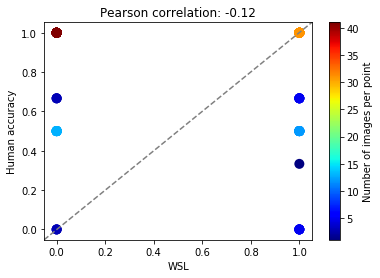

The number users for GradCAM is 114
The correlation b/w proxy metric and human accuracy is:
[[ 1.        -0.0806867]
 [-0.0806867  1.       ]]
-0.0806866958820842


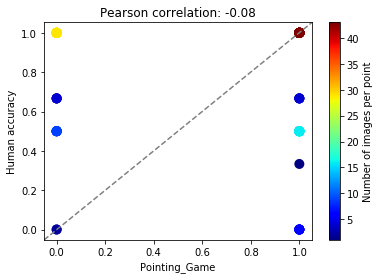

The number users for GradCAM is 114
The correlation b/w proxy metric and human accuracy is:
[[ 1.         -0.11212165]
 [-0.11212165  1.        ]]
-0.11212164913780674


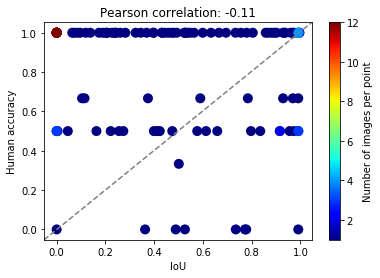

The number users for EP is 130
The correlation b/w proxy metric and human accuracy is:
[[1.         0.03176505]
 [0.03176505 1.        ]]
0.0317650535264315


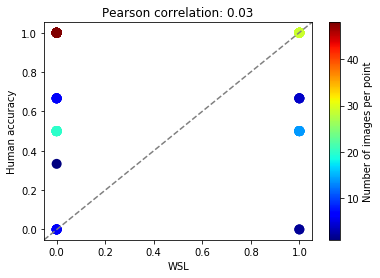

The number users for EP is 130
The correlation b/w proxy metric and human accuracy is:
[[1.         0.07363391]
 [0.07363391 1.        ]]
0.07363391459495931


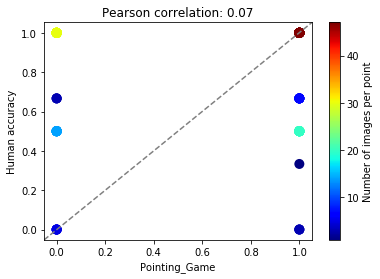

The number users for EP is 130
The correlation b/w proxy metric and human accuracy is:
[[1.         0.03571334]
 [0.03571334 1.        ]]
0.03571334297215785


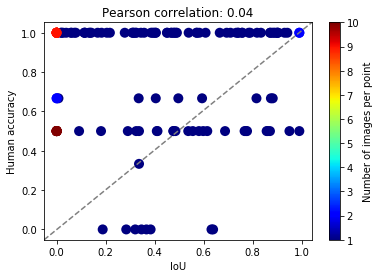

In [8]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

import csv
for test_method in ['GradCAM', 'EP']:
    for test_metric in ['WSL', 'Pointing_Game', 'IoU']:
        human_acc_dict = dict()
        for trial_key, value in test_correct_trials_dict[test_method].items():
            # 48 is the len of un-attacked images. e.g. n03857828_ILSVRC2012_val_00009423_n03857828.jpeg
            if len(trial_key) <= 48:
                key = trial_key.split('.jpeg')[0]
                if exp not in human_acc_dict:
                    human_acc_dict[exp] = dict()
                if value['Prediction'] not in human_acc_dict[exp]:
                    human_acc_dict[exp][value['Prediction']] = dict()

                # Normalize correct count on an image on the number of users saw the image
        #         human_acc_dict['Natural'][value['Prediction']][key] = value['Count']
                # Filter out images only seen by one person
                if len(test_correct_trials_dict[test_method][trial_key]['Counter balance']) > 1:
                    human_acc_dict[exp][value['Prediction']][key] = value['Count']/len(test_correct_trials_dict[test_method][trial_key]['Counter balance'])
        #     else:
        #         if 'Adversarial_Nat' not in human_acc_dict:
        #             human_acc_dict['Adversarial_Nat'] = dict()
        # #         human_acc_dict['Adversarial_Nat'][key] = value['Count']
        #         if len(test_correct_trials_dict[test_method][trial_key]['Counter balance']):
        #             human_acc_dict['Adversarial_Nat'][key] = value['Count']/len(test_correct_trials_dict[test_method][trial_key]['Counter balance'])
        human_acc_dict[exp]['Correct'] = {k: human_acc_dict[exp]['Correct'][k] for k in sorted(human_acc_dict[exp]['Correct'])}     
        
        
        if exp == 'Natural':
            metric_csv = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/saliency_maps/{}_{}_resnet34_{}_metrics.csv'.format(test_metric, test_method, 'ImageNet')
        else:
            metric_csv = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/saliency_maps/{}_{}_resnet34_{}_metrics.csv'.format(test_metric, test_method, exp)

        reader = csv.reader(open(metric_csv))
        definition_dict = dict()
        proxy_acc_dict = dict()
        for row in reader:
            key = row[0].split('.npy')[0]
            if test_metric == 'IoU':
                proxy_acc_dict[key] = float(row[1])
            elif test_metric == 'WSL': 
                if float(row[1]) > 0:
                    value = 0
                else:
                    value = 1
                proxy_acc_dict[key] = value
            elif test_metric == 'Pointing_Game': 
                if float(row[1]) > 0:
                    value = 1
                else:
                    value = 0
                proxy_acc_dict[key] = value


        proxy_acc_dict = {k: proxy_acc_dict[k] for k in sorted(proxy_acc_dict)}

        human_acc = []
        proxy_acc = []
        for key, value in human_acc_dict[exp]['Correct'].items():
            human_acc.append(value)
            proxy_acc.append(proxy_acc_dict[key])
        print('The number users for {} is {}'.format(test_method, len(human_acc)))
        print('The correlation b/w proxy metric and human accuracy is:')
        pearson_matrix = np.corrcoef(proxy_acc, human_acc)
        print(pearson_matrix)
        pearson_coeff = pearson_matrix[0][1]
        print(pearson_coeff)
        
        from scipy.stats import gaussian_kde
        
        density = dict()
        for idx, _ in enumerate(proxy_acc):
            if (proxy_acc[idx], human_acc[idx]) in density:
                density[(proxy_acc[idx], human_acc[idx])] += 1
            else:
                density[(proxy_acc[idx], human_acc[idx])] = 1
        
        z = []
        for idx, _ in enumerate(proxy_acc):
            z.append(density[(proxy_acc[idx], human_acc[idx])])
        z_arr = np.array(z)
            
        x = proxy_acc
        y = human_acc

        # Calculate the point density
        xy = np.vstack([x,y])
#         z = gaussian_kde(xy)(xy)

        fig, ax = plt.subplots()
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='grey')
        cm = plt.cm.jet
        sc = ax.scatter(x, y, c=z_arr, s=100, vmin=z_arr.min(), vmax=z_arr.max(), edgecolor='', cmap=cm)
        
        plt.title('Pearson correlation: {}'.format(round(pearson_coeff,2)))
        plt.ylabel('Human accuracy')
        plt.xlabel(test_metric)
        plt.colorbar(sc, label='Number of images per point')
        plt.savefig('correlation_figures/{}_{}_{}.pdf'.format(exp, test_method, test_metric),dpi=300, format='pdf', bbox_inches='tight')
        plt.show()

In [ ]:
acc_hist = dict()
for IoU in proxy_acc:
    interval = int(IoU*10)
    if interval in acc_hist:
        acc_hist[interval] += 1
    else:
        acc_hist[interval] = 1
acc_hist = {k: acc_hist[k] for k in sorted(acc_hist)}
ax = plt.figure().gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(proxy_acc, density=False, bins=10, ec='black')  # density=False would make counts
plt.title(test_method)
plt.ylabel('Numb. of images')
plt.xlabel(test_metric)
plt.show()
plt.close()

In [ ]:
# Explain: Why SOD is the best method in Natural Dogs wrong images
# wrong images that was corrected by SOD but not others
# Now we have 74 keys, the representative should be not in any other methods
target_method = 'SOD'
candidates = []
cnt = 0
cnt_balance = 0
for key in test_correct_trials_dict[target_method].keys():
    # Only care wrong images | If the image were recognized by all users | And the image should be Natural not Adversarial
    if test_correct_trials_dict[target_method][key]['Prediction'] == 'Wrong' \
    and test_correct_trials_dict[target_method][key]['Count'] == len(test_correct_trials_dict[target_method][key]['Counter balance']) \
    and test_correct_trials_dict[target_method][key]['Task'] == 'Dog' \
    and len(test_correct_trials_dict[target_method][key]['Counter balance']) > cnt_balance:
#         print(test_correct_trials_dict['SOD'][key])
        cnt += 1
        candidates.append(key)
print(cnt)

representatives = []
for candidate in candidates:
    flag = True
    flag_cnt = 0
    for method in ['EP', 'NNs', 'GradCAM']:
        if candidate in test_correct_trials_dict[method] and len(test_correct_trials_dict[method][candidate]['Counter balance']) > cnt_balance:
#             print(test_correct_trials_dict[method][candidate]['Count'], len(test_correct_trials_dict[method][candidate]['Counter balance']))
            if test_correct_trials_dict[method][candidate]['Count'] < len(test_correct_trials_dict[method][candidate]['Counter balance']):
#             if test_correct_trials_dict[method][candidate]['Count'] < 2:
                flag_cnt += 1
#                 break

    if flag_cnt == 3:
        representatives.append(candidate)
print(len(representatives))
print(representatives)
# print(candidates)

data_path = '/home/dexter/Downloads/Human_experiments/Visualization/{}/'.format('Dog')
dst_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/SOD_wrong_dogs'
dst_aggregate_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/SOD_wrong_dogs_aggregate/'


from shutil import copyfile

# Now we have the representatives, we copy the explanations (GradCAM, EP, ....) on the representatives to a folder
for representative in representatives:
    cmd = 'montage'
    representative_idx = representative.split('.jpeg')[0]
    for method in ['SOD', 'GradCAM', 'EP', 'NNs']:
        method_path = method
        if method == 'SOD':
            method_path = 'PoolNet'
        method_path = os.path.join(data_path, method_path)
        vis_paths = glob.glob(method_path + '/*.*')
        for vis_path in vis_paths:
            if representative_idx in vis_path:
                src = vis_path
                dst = os.path.join(dst_path, representative_idx + '_' + method + '.jpeg')
                cmd += ' ' + dst
                copyfile(src, dst)
                if method == 'Conf':
                    size = '600x600'
                elif method in ['GradCAM', 'EP', 'SOD']:
                    size = '1200x600'
                else:
                    size = '2400x600'
                if method == 'NNs':
                    method = '3-NNs'
                os.system('convert {} -resize {}\! -pointsize 28 -gravity North -background White -splice 0x32 -annotate +0+4 "{}" {}'.format(dst, size, method, dst))
    aggregate_path = os.path.join(dst_aggregate_path, representative)
    
    
    gt_label = representative[34:43]
    print(representative)
    sample_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/sample_images'
    predicted_sample_path = os.path.join(sample_path, gt_label + '.jpeg')
    
    textual_label = id_map.get(gt_label).split(',')[0]
    textual_label = textual_label[0].lower() + textual_label[1:]
    definition = '{}: {}'.format(textual_label, definition_dict[gt_label])
    print(definition)
    os.system('convert  -font Times-New-Roman {} -pointsize 12 -gravity North -background White -splice 0x32 -annotate +0+4 "{}" {}'.format(predicted_sample_path, definition, representative))
    
    cmd += ' ' + representative
    print(gt_label)
    cmd += ' -tile 1x5 -geometry 2400x600+0+0 ' +  aggregate_path
    os.system(cmd)
    

In [ ]:
# Explain: Why showing visual explanations does more harm than good in Adversarial Dogs - the hardest task
target_method = 'Conf'
candidates = []
cnt = 0
cnt_balance = 0
for key in test_correct_trials_dict[target_method].keys():
    # Only care wrong images | If the image were recognized by all users | And the image should be Natural not Adversarial
    if test_correct_trials_dict[target_method][key]['Prediction'] == 'Wrong' \
    and test_correct_trials_dict[target_method][key]['Count'] == len(test_correct_trials_dict[target_method][key]['Counter balance']) \
    and test_correct_trials_dict[target_method][key]['Task'] == 'Adversarial_Dog' \
    and len(test_correct_trials_dict[target_method][key]['Counter balance']) > cnt_balance:
#         print(test_correct_trials_dict['SOD'][key])
        cnt += 1
        candidates.append(key)
print(cnt)

representatives = []
for candidate in candidates:
    flag = True
    flag_cnt = 0
    for method in ['GradCAM', 'EP', 'NNs']:
        if candidate in test_correct_trials_dict[method] and len(test_correct_trials_dict[method][candidate]['Counter balance']) > cnt_balance:
#             print(test_correct_trials_dict[method][candidate]['Count'], len(test_correct_trials_dict[method][candidate]['Counter balance']))
            if test_correct_trials_dict[method][candidate]['Count'] < len(test_correct_trials_dict[method][candidate]['Counter balance']):
#             if test_correct_trials_dict[method][candidate]['Count'] < 2:
                flag_cnt += 1
#                 break

    if flag_cnt == 3:
        representatives.append(candidate)
print(len(representatives))
print(representatives)
# print(candidates)

data_path = '/home/dexter/Downloads/Human_experiments/Visualization/{}/'.format('Adversarial_Dog')
dst_path = 'Finding_explanations/Conf_adversarial_dog'
dst_aggregate_path = 'Finding_explanations/Conf_adversarial_dog_aggregate/'


from shutil import copyfile

# Now we have the representatives, we copy the explanations (GradCAM, EP, ....) on the representatives to a folder
for representative in representatives:
    cmd = 'montage'
    representative_idx = representative.split('.jpeg')[0]
    for method in ['GradCAM', 'EP', 'NNs']:
        method_path = method
        if method == 'SOD':
            method_path = 'PoolNet'
        method_path = os.path.join(data_path, method_path)
        vis_paths = glob.glob(method_path + '/*.*')
        for vis_path in vis_paths:
            if representative_idx in vis_path:
                src = vis_path
                dst = os.path.join(dst_path, representative_idx + '_' + method + '.jpeg')
                cmd += ' ' + dst
                copyfile(src, dst)
                if method == 'Conf':
                    size = '600x600'
                elif method in ['GradCAM', 'EP', 'SOD']:
                    size = '1200x600'
                else:
                    size = '2400x600'
                if method == 'NNs':
                    method = '3-NNs'
                os.system('convert {} -resize {}\! -pointsize 28 -gravity North -background White -splice 0x32 -annotate +0+4 "{}" {}'.format(dst, size, method, dst))
    aggregate_path = os.path.join(dst_aggregate_path, representative)
    
    gt_label = representative[34:43]
    print(representative)
    sample_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/sample_images'
    predicted_sample_path = os.path.join(sample_path, gt_label + '.jpeg')
    print(gt_label)
    textual_label = id_map.get(gt_label).split(',')[0]
    textual_label = textual_label[0].lower() + textual_label[1:]
    definition = '{}: {}'.format(textual_label, definition_dict[gt_label])
    print(definition)
    os.system('convert  -font Times-New-Roman {} -pointsize 12 -gravity North -background White -splice 0x32 -annotate +0+4 "{}" {}'.format(predicted_sample_path, definition, representative))
    
    cmd += ' ' + representative
    print(gt_label)
    
    cmd += ' -tile 1x4 -geometry 2400x600+0+0 ' +  aggregate_path
    os.system(cmd)
    